In [15]:
import pandas as pd
import numpy as np
import datetime
import socket
import struct
import matplotlib.pyplot as plt

In [2]:
headerString = "date time time-taken c-ip cs-username cs-auth-group x-exception-id sc-filter-result cs-categories cs(Referer) sc-status s-action cs-method rs(Content-Type) cs-uri-scheme cs-host cs-uri-port cs-uri-path cs-uri-query cs-uri-extension cs(User-Agent) s-ip sc-bytes cs-bytes x-virus-id"
header=headerString.split(" ")
a = pd.read_csv('./Data/message.txt', delimiter="\s+", index_col=False, encoding="utf-8", comment='#',names=header)


C:\Users\VRUma\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (10,16,22,23) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [102]:
#drop columns : cs-unsername cs-auth-group  (date prob)
df1 = a.sample(frac=0.5,random_state=200) 
df2 =df1.sample(frac=0.5,random_state=200)

df1=df1.drop(columns=['cs-username','cs-auth-group','date',
                      'time-taken','cs(Referer)','cs-method',
                      'rs(Content-Type)','cs-host','cs-uri-path',
                      'cs-uri-query','cs-uri-extension','cs(User-Agent)','s-ip','x-virus-id'])

df3=df1.sample(frac=0.4,random_state=2000)
df3=df3.reset_index()


In [103]:
y=df1.tail(1)

def preprocessing(data):
    data=data.dropna()
    data.loc[data['x-exception-id'] == '-', 'x-exception-id'] = ""
    return data

    

In [104]:
def compute_similarity(string1,stand_val):
    indexes=np.where(string1==stand_val)
    return indexes[0]


def apply_sim(data,column_name,one_line_df,new_col_name):
    if column_name not in data.columns:
        print("Wrong column name")
        return 0
    else :
        list_indexes=compute_similarity(data[column_name].values,one_line_df[column_name].values[0])
        data[new_col_name]=data.index.isin(list_indexes)
        data[new_col_name]=data[new_col_name].astype(int)
    return data

    


In [105]:
def compute_all_sims(data,y):
    all_cols=data.columns.tolist()[3:]
    all_cols
    for col in all_cols:
        apply_sim(data,col,y,'sim')
        if 'final_sim' not in data.columns :
            data['final_sim'] = data['sim']
        else :
            data['final_sim']= data['final_sim'] + data['sim']
    return data
df3=preprocessing(df3)
compute_all_sims(df3,y)

C:\Users\VRUma\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,index,time,c-ip,x-exception-id,sc-filter-result,cs-categories,sc-status,s-action,cs-uri-scheme,cs-uri-port,sc-bytes,cs-bytes,sim,final_sim
0,888563,21:17:48,922e695d8efdd9c2,,OBSERVED,unavailable,400,TCP_NC_MISS,http,80,221,680,0,4
1,178358,20:43:03,b1667d277a0eea24,,OBSERVED,unavailable,403,TCP_NC_MISS,http,80,504,920,0,4
2,290791,20:48:19,6d98469a3f1de6f4,,OBSERVED,unavailable,200,TCP_MISS,http,80,8402,427,0,5
3,990959,21:23:00,dd60f0927674ae4a,,OBSERVED,unavailable,200,TCP_NC_MISS,http,80,914,1184,0,5
4,21654,20:35:51,ee73ceddd52050f0,,OBSERVED,unavailable,200,TCP_HIT,http,80,1115,887,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208361,470464,20:57:13,2ced9adaec5b4b7d,internal_error,DENIED,unavailable;unavailable,0,TCP_ERR_MISS,-,0,0,50,0,0
208362,72924,20:38:16,2056caa323b6174a,,OBSERVED,unavailable,400,TCP_NC_MISS,http,80,221,411,0,0
208363,407358,20:54:04,1b28b4270a6cacfd,,OBSERVED,unavailable,200,TCP_NC_MISS,http,80,3600,1339,0,0
208364,357878,20:51:32,d23491d9a5ae7146,,OBSERVED,unavailable,200,TCP_NC_MISS,http,80,182,192,0,0


In [106]:
def normalization(data):
    df4=data.copy()
    df4['final_sim']=(df4['final_sim']-df4['final_sim'].mean())/df4['final_sim'].std()
    #df4 = df4.drop([283551], axis=0)
    df4['sc-bytes'] = pd.to_numeric(df4['sc-bytes'])
    df4['cs-bytes'] = pd.to_numeric(df4['cs-bytes'])
    df4['sc-bytes']=(df4['sc-bytes']-df4['sc-bytes'].mean())/df4['sc-bytes'].std()
    df4['cs-bytes']=(df4['cs-bytes']-df4['cs-bytes'].mean())/df4['cs-bytes'].std()
    return df4


def normalization2(data):
    df4=data.copy()
    df4['final_sim']=(df4['final_sim']-df4['final_sim'].min())/(df4['final_sim'].max() -df4['final_sim'].min()) 
    #df4 = df4.drop([283551], axis=0)
    df4['sc-bytes'] = pd.to_numeric(df4['sc-bytes'])
    df4['cs-bytes'] = pd.to_numeric(df4['cs-bytes'])
    df4['sc-bytes']=(df4['sc-bytes']-df4['sc-bytes'].min())/(df4['sc-bytes'].max() -df4['sc-bytes'].min()) 
    df4['cs-bytes']=(df4['cs-bytes']-df4['cs-bytes'].min())/(df4['cs-bytes'].max() -df4['cs-bytes'].min()) 
    return df4


dfn=normalization(df3)


In [107]:
dfn.sort_values(by=['cs-bytes'],ascending=False)
dfn1=dfn.sample(frac=0.1,random_state=1337)

In [108]:
dfn1

,index,time,c-ip,x-exception-id,sc-filter-result,cs-categories,sc-status,s-action,cs-uri-scheme,cs-uri-port,sc-bytes,cs-bytes,sim,final_sim
186501,390877,20:53:14,0e8fe56c260eb807,,OBSERVED,unavailable,200,TCP_NC_MISS,http,80,-0.037101,-0.009094,0,-1.271659
43097,74853,20:38:21,0e8fe56c260eb807,,OBSERVED,unavailable,200,TCP_NC_MISS,http,80,-0.039691,0.052861,0,0.322184
105183,126461,20:40:43,98acef34ff9f9df0,,OBSERVED,unavailable,304,TCP_HIT,http,80,-0.040975,0.007413,0,1.119105
33186,666750,21:07:00,922e695d8efdd9c2,,OBSERVED,unavailable,400,TCP_NC_MISS,http,80,-0.041040,-0.012899,0,0.322184
47924,439530,20:55:42,086c870fa3df9142,internal_error,DENIED,unavailable;unavailable,0,TCP_ERR_MISS,-,0,-0.041235,-0.045269,0,0.322184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172379,294518,20:48:30,48fd5c69d3cfc0af,,OBSERVED,unavailable,403,TCP_NC_MISS,http,80,-0.040594,-0.032032,0,0.322184
148792,171403,20:42:45,561fb474a545a737,,OBSERVED,unavailable,304,TCP_HIT,http,80,-0.041049,-0.005181,0,0.322184
179590,658454,21:06:36,d23491d9a5ae7146,,OBSERVED,unavailable,200,TCP_NC_MISS,http,80,-0.041074,-0.038892,0,0.322184
77857,359771,20:51:38,ef281b5b42c76960,,OBSERVED,unavailable,200,TCP_HIT,http,80,-0.040121,0.030941,0,1.119105


In [109]:
from sklearn.cluster import DBSCAN

#dfn=dfn.dropna()
clusters = DBSCAN(eps = 0.1, min_samples=100)
clusters.fit(dfn1[['sc-bytes','cs-bytes','final_sim']])
dfn1['labels'] = [str(e) for e in clusters.labels_]

dfn1



,index,time,c-ip,x-exception-id,sc-filter-result,cs-categories,sc-status,s-action,cs-uri-scheme,cs-uri-port,sc-bytes,cs-bytes,sim,final_sim,labels
186501,390877,20:53:14,0e8fe56c260eb807,,OBSERVED,unavailable,200,TCP_NC_MISS,http,80,-0.037101,-0.009094,0,-1.271659,0
43097,74853,20:38:21,0e8fe56c260eb807,,OBSERVED,unavailable,200,TCP_NC_MISS,http,80,-0.039691,0.052861,0,0.322184,1
105183,126461,20:40:43,98acef34ff9f9df0,,OBSERVED,unavailable,304,TCP_HIT,http,80,-0.040975,0.007413,0,1.119105,2
33186,666750,21:07:00,922e695d8efdd9c2,,OBSERVED,unavailable,400,TCP_NC_MISS,http,80,-0.041040,-0.012899,0,0.322184,1
47924,439530,20:55:42,086c870fa3df9142,internal_error,DENIED,unavailable;unavailable,0,TCP_ERR_MISS,-,0,-0.041235,-0.045269,0,0.322184,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172379,294518,20:48:30,48fd5c69d3cfc0af,,OBSERVED,unavailable,403,TCP_NC_MISS,http,80,-0.040594,-0.032032,0,0.322184,1
148792,171403,20:42:45,561fb474a545a737,,OBSERVED,unavailable,304,TCP_HIT,http,80,-0.041049,-0.005181,0,0.322184,1
179590,658454,21:06:36,d23491d9a5ae7146,,OBSERVED,unavailable,200,TCP_NC_MISS,http,80,-0.041074,-0.038892,0,0.322184,1
77857,359771,20:51:38,ef281b5b42c76960,,OBSERVED,unavailable,200,TCP_HIT,http,80,-0.040121,0.030941,0,1.119105,2


In [110]:
dfn1.groupby('labels').count()

,index,time,c-ip,x-exception-id,sc-filter-result,cs-categories,sc-status,s-action,cs-uri-scheme,cs-uri-port,sc-bytes,cs-bytes,sim,final_sim
labels,,,,,,,,,,,,,,
-1,265,265,265,265,265,265,265,265,265,265,265,265,265,265
0,668,668,668,668,668,668,668,668,668,668,668,668,668,668
1,9585,9585,9585,9585,9585,9585,9585,9585,9585,9585,9585,9585,9585,9585
2,3507,3507,3507,3507,3507,3507,3507,3507,3507,3507,3507,3507,3507,3507
3,908,908,908,908,908,908,908,908,908,908,908,908,908,908
4,5689,5689,5689,5689,5689,5689,5689,5689,5689,5689,5689,5689,5689,5689
5,151,151,151,151,151,151,151,151,151,151,151,151,151,151


In [116]:
dfn1.loc[dfn1['labels']=="5"]

,index,time,c-ip,x-exception-id,sc-filter-result,cs-categories,sc-status,s-action,cs-uri-scheme,cs-uri-port,sc-bytes,cs-bytes,sim,final_sim,labels
109235,969712,21:21:55,96ba5993c403a175,,OBSERVED,unavailable,204,TCP_NC_MISS,http,80,-0.041038,-0.010058,0,-2.865501,5
113747,546968,21:01:02,2056caa323b6174a,,OBSERVED,unavailable,400,TCP_NC_MISS,http,80,-0.041040,-0.027101,0,-2.865501,5
89641,209878,20:44:29,5e8fa70577328701,,OBSERVED,unavailable,200,TCP_HIT,http,80,-0.040892,-0.025279,0,-2.865501,5
116276,234098,20:45:35,35e50eed1eda095b,,OBSERVED,unavailable,0,TCP_NC_MISS,http,80,-0.041235,0.002697,0,-2.865501,5
184511,897005,21:18:16,922e695d8efdd9c2,,OBSERVED,unavailable,400,TCP_NC_MISS,http,80,-0.041040,-0.012899,0,-2.865501,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141148,151408,20:41:50,35e50eed1eda095b,,OBSERVED,unavailable,0,TCP_NC_MISS,http,80,-0.041235,0.005109,0,-2.865501,5
87239,855998,21:16:16,6d98469a3f1de6f4,,OBSERVED,unavailable,200,TCP_HIT,http,80,-0.038000,-0.022760,0,-2.865501,5
146271,904357,21:18:38,95f6f747cf5755b3,internal_error,DENIED,unavailable;unavailable,0,TCP_ERR_MISS,-,0,-0.041235,-0.046609,0,-2.865501,5
184750,924347,21:19:38,6d98469a3f1de6f4,,OBSERVED,unavailable,200,TCP_HIT,http,80,-0.040355,-0.013595,0,-2.865501,5


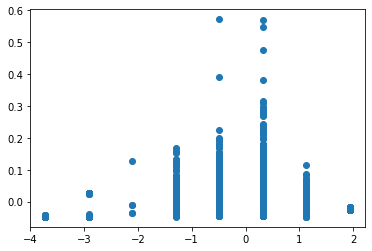

In [20]:

dfn2=dfn1.loc[dfn1['cs-bytes']<1]
plt.scatter(dfn2['final_sim'],dfn2['cs-bytes'])

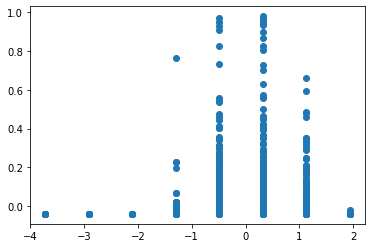

In [21]:
dfn2=dfn2.loc[dfn2['sc-bytes']<1]

plt.scatter(dfn2['final_sim'],dfn2['sc-bytes'])